## Version 3
Okay we need to refactor this whole thing (version 02), to be more maintainable, and prepared for putting into production.
Also the devops guys say they are now enforcing pull requests with code quality checking so our code needs to be less "smelly" or the pull request won't be accepted. Installing Ruff can help with that apparently.  
Also DONT COMMIT DIRECTLY TO MAIN!

Add autoreload since we are now modifying scripts in other folders.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Getting the data again.

In [4]:

import sys
import os

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.preproc import get_raw_data
from ARISA_DSML.config import RAW_DATA_DIR, target, categorical

2025-03-08 08:26:15.310 | INFO     | ARISA_DSML.config:<module>:12 - PROJ_ROOT path is: C:\Users\claus\source\repos\ARISA-MLOps


In [5]:

import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [6]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-03-08 08:26:19.229 | INFO     | ARISA_DSML.preproc:get_raw_data:22 - RAW_DATA_DIR is: C:\Users\claus\source\repos\ARISA-MLOps\data\raw


Dataset URL: https://www.kaggle.com/datasets/wesleyhowe/titanic-labelled-test-set
 Volume in drive C is Windows
 Volume Serial Number is 9AF9-C650

 Directory of C:\Users\claus\source\repos\ARISA-MLOps\data\raw

08/03/2025  08:26 am    <DIR>          .
08/03/2025  08:26 am    <DIR>          ..
08/03/2025  08:26 am             3,258 gender_submission.csv
08/03/2025  08:26 am            28,629 test.csv
08/03/2025  08:26 am            30,234 test_augmented.csv
08/03/2025  08:26 am            61,194 train.csv
               4 File(s)        123,315 bytes
               2 Dir(s)  146,675,965,952 bytes free


Load preproc from preproc.py and run on train data:

In [7]:
from ARISA_DSML.preproc import preprocess_df

train_path = preprocess_df(RAW_DATA_DIR / "train.csv")

In [8]:
train_path

WindowsPath('C:/Users/claus/source/repos/ARISA-MLOps/data/processed/train.csv')

In [9]:
import pandas as pd
df_train = pd.read_csv(train_path)
df_train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
 10  Deck         891 non-null    object 
 11  CabinNumber  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


Split into X and y, get categorical indices:

In [11]:
y_train = df_train.pop(target)
X_train = df_train

categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
categorical_indices

[1, 2, 7, 9, 8]

And run the hyperparameter optimization (if ):

In [20]:
from ARISA_DSML.train import run_hyperopt

best_params_path = run_hyperopt(X_train, y_train, categorical_indices)

2025-03-08 08:31:26.692 | INFO     | ARISA_DSML.train:run_hyperopt:55 - Best Parameters: {"depth": 3, "learning_rate": 0.2847856453953337, "iterations": 101, "l2_leaf_reg": 0.08064725446361332, "bagging_temperature": 0.4441828029429478, "random_strength": 9.931197047043607}


Do cross validation again:

In [15]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
display(params)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, categorical_indices, params, n=n_folds)

{'depth': 3,
 'learning_rate': 0.2847856453953337,
 'iterations': 101,
 'l2_leaf_reg': 0.08064725446361332,
 'bagging_temperature': 0.4441828029429478,
 'random_strength': 9.931197047043607}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7145359	test: 0.7857143	best: 0.7857143 (0)	total: 12.9ms	remaining: 1.29s
1:	learn: 0.6951673	test: 0.7575758	best: 0.7857143 (0)	total: 29.1ms	remaining: 1.44s
2:	learn: 0.6962963	test: 0.7851852	best: 0.7857143 (0)	total: 45.1ms	remaining: 1.47s
3:	learn: 0.7091932	test: 0.7851852	best: 0.7857143 (0)	total: 60.2ms	remaining: 1.46s
4:	learn: 0.7091932	test: 0.7851852	best: 0.7857143 (0)	total: 74.9ms	remaining: 1.44s
5:	learn: 0.7091932	test: 0.7851852	best: 0.7857143 (0)	total: 81.3ms	remaining: 1.29s
6:	learn: 0.7129456	test: 0.7851852	best: 0.7857143 (0)	total: 96.7ms	remaining: 1.3s
7:	learn: 0.7142857	test: 0.7851852	best: 0.7857143 (0)	total: 112ms	remaining: 1.31s
8:	learn: 0.7249071	test: 0.7969925	best: 0.7969925 (8)	total: 128ms	remaining: 1.3s
9:	learn: 0.7221172	test: 0.7938931	best: 0.7969925 (8)	total: 143ms	remaining: 1.3s
10:	learn: 0.7221172	test: 0.7938931	best: 0.7969925 (8)	total: 158ms	remaining: 1.29s
11:	learn: 0.7293233	test:

And get the performance plots:

In [22]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results,
    name="Mean F1 Score",
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1],
)

In [23]:
plot_error_scatter(
    df_plot=cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)


Fit model on full dataset:

In [24]:
from ARISA_DSML.train import train
model_path, model_params_path = train(X_train, y_train, categorical_indices, params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7044776	total: 12ms	remaining: 1.2s
50:	learn: 0.7968750	total: 684ms	remaining: 671ms
100:	learn: 0.8452012	total: 1.44s	remaining: 0us


And now for the test set, because of our refactor, we don't need to copy paste anymore:

In [25]:
dataset_test_path = RAW_DATA_DIR / "test.csv"
preprocced_test_path = preprocess_df(dataset_test_path)
df_test = pd.read_csv(preprocced_test_path)
df_test["Title"].unique()

df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,CabinNumber
0,892,3,male,34.5,0,0,7.8292,Q,Mr,N,47
1,893,3,female,47.0,1,0,7.0000,S,Mrs,N,47
2,894,2,male,62.0,0,0,9.6875,Q,Mr,N,47
3,895,3,male,27.0,0,0,8.6625,S,Mr,N,47
4,896,3,female,22.0,1,1,12.2875,S,Mrs,N,47


In [26]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,CabinNumber
0,1,3,male,22.0,1,0,7.2500,S,Mr,N,50
1,2,1,female,38.0,1,0,71.2833,C,Mrs,C,85
2,3,3,female,26.0,0,0,7.9250,S,Miss,N,50
3,4,1,female,35.0,1,0,53.1000,S,Mrs,C,123
4,5,3,male,35.0,0,0,8.0500,S,Mr,N,50


Get predictions and shap plot:

{'depth': 3,
 'learning_rate': 0.2847856453953337,
 'iterations': 101,
 'l2_leaf_reg': 0.08064725446361332,
 'bagging_temperature': 0.4441828029429478,
 'random_strength': 9.931197047043607,
 'eval_metric': 'F1',
 'loss_function': 'Logloss',
 'ignored_features': [0],
 'feature_columns': Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked', 'Title', 'Deck', 'CabinNumber'],
       dtype='object')}

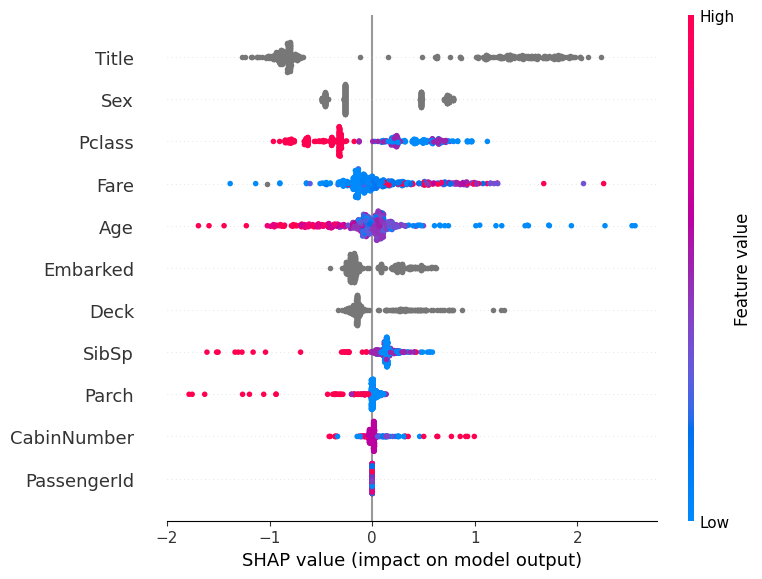

In [27]:
from ARISA_DSML.predict import predict
from catboost import CatBoostClassifier

params = joblib.load(model_params_path)
display(params)
from_file = CatBoostClassifier()
model = from_file.load_model(str(model_path))
preds_path = predict(model, df_test, params)


And that's it for the refactor.  
As can be seen from the notebook, the goal is to have as little code as possible in the actual notebook cells,  
which makes it much easier to maintain and, as we will see shortly, productionalize.